Este colab fue desarrollado por Arnold Charry Armero.

# Árboles de Decisión (Regresión)

Los Árboles de Decisión son modelos supervisados que buscan predecir la salida de nuevas observaciones a partir de reglas aprendidas en los datos de entrenamiento. Para ello, realizan particiones sucesivas del espacio de características en función de umbrales que buscan minimizar una función de error. Lo primero que se hace para construir un Árbol de Decisión es calcular el valor de los umbrales en la función objetivo del $\text{MSE}$ y se selecciona cual de estos es el que la minimiza, para así escogerlo y realizar la primer partición. Después, se continúa con más umbrales en la segunda división para obtener otra partición usando el mismo criterio que en la partición uno y así se continúa con más particiones. La función objetivo del $\text{MSE}$ junto a su formulación matemática es la siguiente:

$$  R_{1}\left ( j, s \right ) = \left\{ X | X_{j} < s\right\} \wedge  R_{2}\left ( j, s \right ) = \left\{ X | X_{j} \geq  s\right\} $$

Y teniendo la función objetivo $\text{MSE}$ de las dos regiones como,

$$ \text{min}\: \sum_{i: x_{i}\in R_{1}(j, s)}^{}\left ( y_{i} - \hat{y_{R_{1}}} \right )^{2} + \sum_{i: x_{i}\in R_{2}(j, s)}^{}\left ( y_{i} - \hat{y_{R_{2}}} \right )^{2} $$

Como criterio de parada se tiene una cantidad mínima de puntos dentro de cada región. Se tienen unas buenas particiones, sin embargo, un árbol muy profundo puede sobreajustar. Para evitarlo, se utiliza la poda de complejidad de costo mínimo, que introduce un parámetro
$\alpha $ para penalizar árboles demasiado grandes. El árbol principal $T_{0}$ contiene cada tipo de árbol $T$ para un $\alpha$ específico que minimiza la función de error. Dentro de la función de error $T$ representa el número de hojas que tiene el árbol que se está evaluando. El error penalizado se define como:

$$ \sum_{m=1}^{|T|}\sum_{x_{i}\in R_{m}}^{}\left ( y_{i} - \hat{y_{R_{m}}} \right )^{2} + \alpha\,|T| $$

El $\alpha $ que minimice el error dentro de los árboles evaluados es el que se selecciona y se escoge el árbol asociado a este parámetro. Se utiliza Validación Cruzada para escoger el $\alpha $.

Ahora se continúa con la implementación en código,

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Bases de Datos/Concrete_Data_Yeh.csv')

In [ ]:
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [ ]:
df.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


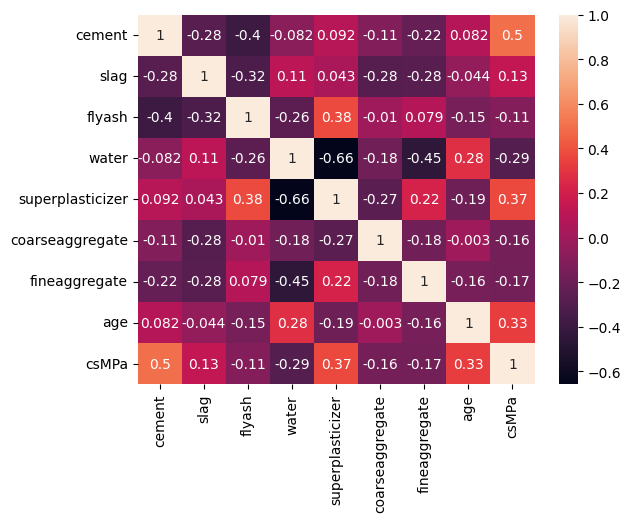

In [ ]:
sns.heatmap(df.corr(), annot=True)
plt.show()

## Preprocesamiento de Datos

In [ ]:
# Obtenemos los vectores
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
# Se detectan las columnas categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_indices = [df.columns.get_loc(col) for col in cat_cols]

# Se detectan las columnas numéricas
num_indices = [i for i in range(df.shape[1] - 1) if i not in cat_indices]

# Se crea el transformador
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first',sparse_output=False, dtype=int), cat_indices)],
                    remainder='passthrough')

## Separación en Base de datos de Entrenamiento y Prueba

In [ ]:
# Se divide la base de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Escalado de Datos

In [ ]:
# Se escalan las variables y se hace one-hot encoder
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
# Se visualiza el array X_train
print(X_train)

[[ 382.     0.     0.  ... 1047.   739.     7. ]
 [ 310.   142.8    0.  ...  914.3  804.    28. ]
 [ 310.     0.     0.  ... 1012.   830.    90. ]
 ...
 [ 144.     0.   175.  ...  943.   844.    28. ]
 [ 239.6  359.4    0.  ...  941.6  664.3   28. ]
 [ 192.   288.     0.  ...  929.8  716.1   90. ]]


## Entrenamiento del Modelo

Se varía en alphas para podar el árbol,

In [ ]:
# Ruta de poda
tree = DecisionTreeRegressor(random_state=0)
tree.fit(X_train, y_train)
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Se evalua cada alpha
val_scores = []
for alpha in ccp_alphas:
    model = DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
    scores = cross_val_score(model, X_train, y_train, cv=5,
                             scoring='neg_mean_squared_error')
    val_scores.append(scores.mean())
val_scores = np.array(val_scores)

# Se escoge el mejor alpha
best_alpha = float(ccp_alphas[np.argmax(val_scores)])
print("Mejor alpha según validación cruzada:", best_alpha)

# Se define rango alrededor del mejor
alpha_min = best_alpha/10 if best_alpha > 0 else ccp_alphas[1]
alpha_max = best_alpha*10 if best_alpha > 0 else ccp_alphas[-1]

# Se hace un submuestreo logarítmico (20 valores)
alphas_reducidos = np.unique(np.logspace(np.log10(alpha_min),
                                         np.log10(alpha_max),
                                         num=20))

print("Cantidad de alphas reducidos:", len(alphas_reducidos))
print(alphas_reducidos)

Mejor alpha según validación cruzada: 0.0024883957466453176
Cantidad de alphas reducidos: 20
[0.00024884 0.00031709 0.00040406 0.00051488 0.0006561  0.00083606
 0.00106536 0.00135757 0.00172991 0.00220439 0.002809   0.00357943
 0.00456118 0.0058122  0.00740634 0.00943771 0.01202624 0.01532474
 0.01952793 0.02488396]


Se entrena el modelo con el alpha seleccionado,

In [ ]:
Decision_Tree_model = DecisionTreeRegressor(random_state = 0, ccp_alpha = best_alpha)
Decision_Tree_model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0024883957466453176, random_state=0)

Realizando una predicción,

In [ ]:
# Se debe de hacer en el orden original
print("Predicción:", Decision_Tree_model.predict(ct.transform([[540.0, 0.0, 0.0, 162.0, 2.5, 978.4, 825.5, 360]]))[0])

Predicción: 74.6


In [ ]:
# Obtenemos las predicciones
y_pred = Decision_Tree_model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[[24.8       ]
 [ 7.615     ]
 [79.3       ]
 [51.02      ]
 [10.76      ]
 [54.1       ]
 [58.52      ]
 [19.42      ]
 [79.395     ]
 [56.14      ]
 [18.        ]
 [40.48      ]
 [39.64      ]
 [12.73      ]
 [55.94      ]
 [56.14      ]
 [42.09      ]
 [35.76      ]
 [59.76      ]
 [35.305     ]
 [56.14      ]
 [26.84      ]
 [21.5       ]
 [59.76      ]
 [14.54      ]
 [25.3375    ]
 [68.3       ]
 [30.55      ]
 [56.14      ]
 [66.82      ]
 [19.475     ]
 [48.85      ]
 [23.87857143]
 [27.83      ]
 [21.52      ]
 [ 4.9       ]
 [35.5       ]
 [25.37      ]
 [30.52333333]
 [28.47      ]
 [39.3       ]
 [31.35      ]
 [32.046     ]
 [41.41      ]
 [37.11      ]
 [33.73333333]
 [24.02333333]
 [24.8       ]
 [32.82      ]
 [51.73      ]
 [41.53666667]
 [27.83      ]
 [16.5       ]
 [39.66333333]
 [54.34      ]
 [44.035     ]
 [31.195     ]
 [47.72      ]
 [64.        ]
 [25.46      ]
 [36.94      ]
 [21.26      ]
 [67.765     ]
 [54.9       ]
 [17.03      ]
 [76.24      ]
 [32.545  

## Rendimiento del Modelo

In [ ]:
# KPI's del Modelo
MAE = mean_absolute_error(y_test, y_pred)
print('MAE: {:0.2f}%'.format(MAE / np.mean(y_test) * 100))
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: {:0.2f}%'.format(RMSE / np.mean(y_test) * 100))
r2 = r2_score(y_test, y_pred)
print('R2: {:0.2f}'.format(r2))

MAE: 13.68%
RMSE: 21.25%
R2: 0.78


## Validación Cruzada y Grid Search

Se mide el error cuadrático medio para la diferente selección de datos de entrenamiento y prueba,

In [ ]:
# Aplicar K-fold Cross Validation
scores = cross_val_score(estimator = Decision_Tree_model, X = X_train, y = y_train, cv = 10, scoring = 'neg_mean_squared_error')
print(-scores.mean())

53.66780336703799


Se conocen los parámetros del Árbol de Decisión para evaluar el GridSearch.

In [ ]:
Decision_Tree_model = DecisionTreeRegressor(random_state = 0)

In [ ]:
# Parámetros
Decision_Tree_model.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])

In [ ]:
# Se establecen los parámetros a probar
parameters = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4],
              'max_features': [None, 'sqrt', 'log2'], 'ccp_alpha': [best_alpha]}

In [ ]:
# Se utiliza GridSearchCV
full_cv_classifier = GridSearchCV(estimator = Decision_Tree_model,
                                  param_grid = parameters,
                                  cv = 10,
                                  scoring = 'neg_mean_squared_error')

In [ ]:
# Se entrena el CV_Classifier
full_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'ccp_alpha': [0.0024883957466453176],
                         'max_depth': [3, 5, 10, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [ ]:
full_cv_classifier.best_params_

{'ccp_alpha': 0.0024883957466453176,
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

In [ ]:
# Se obtiene el mejor resultado
print(-full_cv_classifier.best_score_)

50.626036309919


Ahora se vuelve a entrenar el modelo, pero con los parámetros óptimos.

In [ ]:
model = DecisionTreeRegressor(max_depth = None, max_features = None, min_samples_leaf = 2,
                              min_samples_split = 5, ccp_alpha = best_alpha)
model.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0024883957466453176, min_samples_leaf=2,
                      min_samples_split=5)

In [ ]:
# Obtenemos las predicciones
y_pred = model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[[25.9875    ]
 [ 8.274     ]
 [79.3       ]
 [57.79333333]
 [ 7.80333333]
 [47.26666667]
 [65.22333333]
 [24.78      ]
 [80.18      ]
 [53.765     ]
 [16.08333333]
 [39.6675    ]
 [37.75      ]
 [11.69333333]
 [49.89      ]
 [51.7575    ]
 [42.09      ]
 [32.41666667]
 [55.135     ]
 [38.015     ]
 [51.7575    ]
 [29.49      ]
 [31.995     ]
 [55.135     ]
 [11.67333333]
 [25.12666667]
 [71.06333333]
 [26.425     ]
 [51.7575    ]
 [59.755     ]
 [19.475     ]
 [50.88      ]
 [23.87857143]
 [26.9       ]
 [22.625     ]
 [ 7.80333333]
 [35.12      ]
 [24.78      ]
 [33.0175    ]
 [26.1525    ]
 [37.8       ]
 [37.1825    ]
 [32.046     ]
 [45.5       ]
 [38.46      ]
 [31.63333333]
 [24.68666667]
 [25.9875    ]
 [31.55      ]
 [49.94428571]
 [41.53666667]
 [26.9       ]
 [19.715     ]
 [39.66333333]
 [54.22666667]
 [49.89      ]
 [31.195     ]
 [51.7575    ]
 [64.        ]
 [27.6025    ]
 [40.57      ]
 [24.93      ]
 [67.075     ]
 [51.96666667]
 [17.03      ]
 [70.60333333]
 [40.80333

In [ ]:
# Obteniendo la precisión del modelo
print('RMSE: {:0.2f}%'.format(np.sqrt(mean_squared_error(y_test, y_pred)) / np.mean(y_test) * 100))
print('MAE: {:0.2f}%'.format(mean_absolute_error(y_test, y_pred) / np.mean(y_test) * 100))
print('R2: {:0.2f}%'.format(r2_score(y_test, y_pred) * 100))

RMSE: 20.47%
MAE: 14.17%
R2: 79.16%


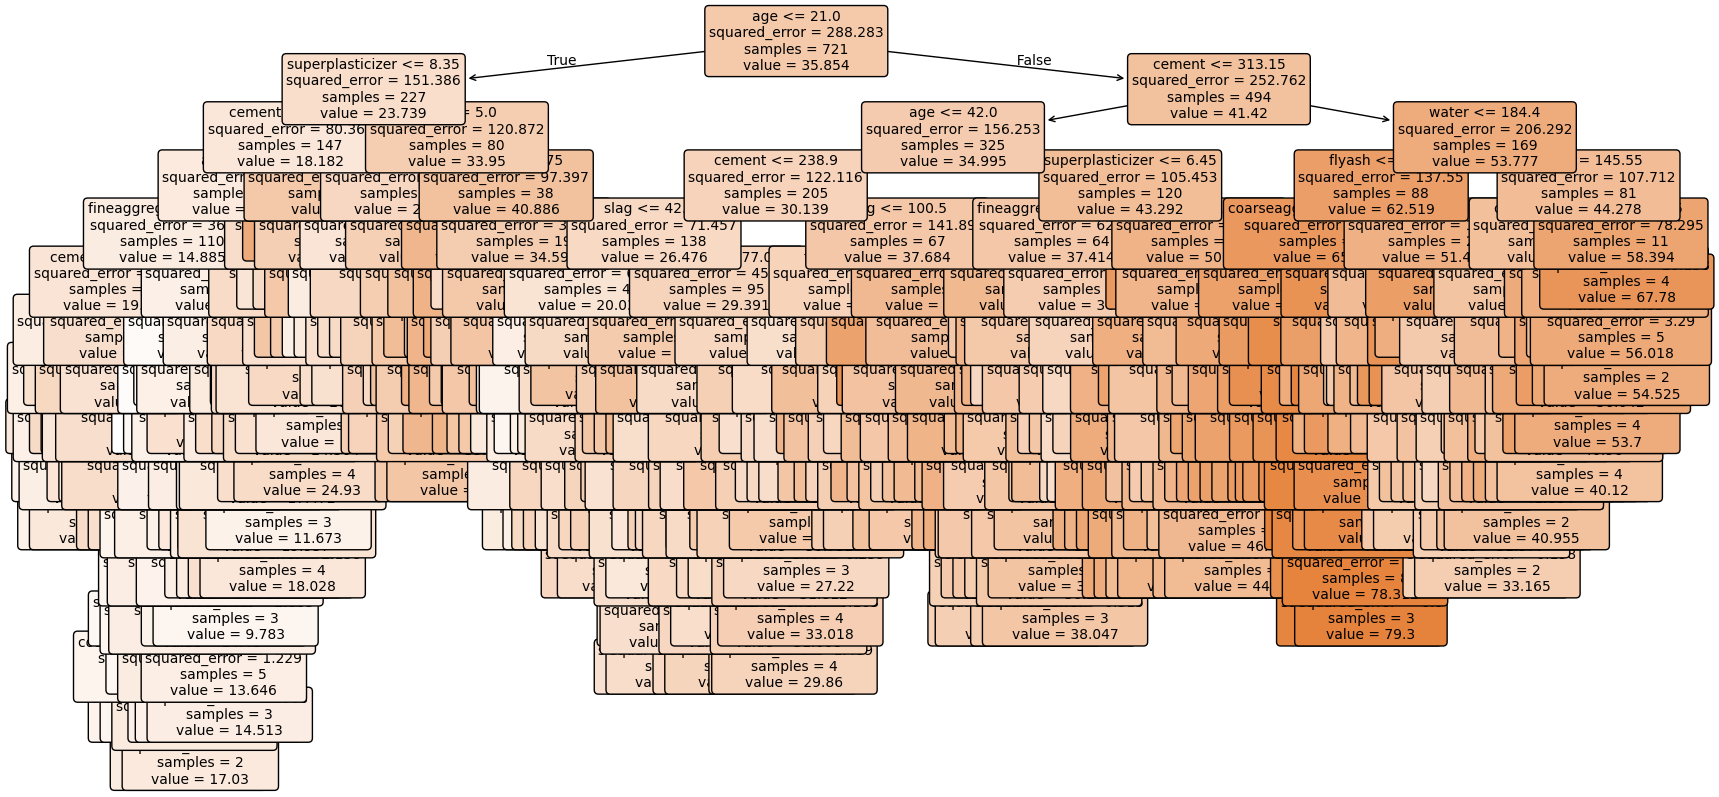

In [ ]:
# Obtener nombres de las columnas
feature_names = df.drop("csMPa", axis=1).columns

# Graficar el árbol de regresión
plt.figure(figsize=(20,10))
plot_tree(model,
          filled=True,
          rounded=True,
          feature_names=feature_names,
          fontsize=10)
plt.show()

## Referencias

*   Jacinto, V. R. (2024). Machine learning: Fundamentos, algoritmos y aplicaciones para los negocios, industria y finanzas. Ediciones Díaz de Santos.
*   James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning: with Applications in R. https://link.springer.com/content/pdf/10.1007/978-1-0716-1418-1.pdf
*   Revisiting  a Concrete Strength regression. (2018, June 15). Kaggle. https://www.kaggle.com/datasets/maajdl/yeh-concret-data
*   Vandeput, N. (2021). Data science for supply chain forecasting. de Gruyter.

